# 4. Preprocesamiento y Modelos del Lenguaje (Neuronal)

<img src="https://2.bp.blogspot.com/-oDvCIkIjwXw/VdWWxfvmq3I/AAAAAAAARUE/r0MrmbNzMz8/s1600/inputoutput.jpg" width=500>

## Objetivos

- Aplicar preprocesamiento a corpus en español e inglés
- Entender el funcionamiento de algoritmos de sub-word tokenization
  - Aplicar BPE a corpus
- Entrenar un modelo del lenguaje neuronal con la arquitectura de Bengio

## ¿Qué es una palabra?

- Tecnicas de procesamiento del lenguaje depende de las palabras y las oraciones.
  - Debemos identificar estos elementos para poder procesarlos
- Este paso de identificación de palabras y oraciones se le llama segmentación de texto o **tokenización** (*tokenization*)
- Además de la identificación de unidades aplicaremos transformaciones al texto

Aunque la definición de lo que es una palabra puede parecer obvia es tremendamente difícil.

- I'm
- we'd
- I've
- Diego's Bicycle

## Elementos del preprocesamiento

- Normalización
    - Pasar todo a minúsculas
    - Pasar texto a cierta norma ortográfica
- Quitar stopwords
- Quitar elementos de marcado (HTML, XML)
- Tokenización

### Stopwords

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from rich import print as rprint

In [ ]:
BASE_PATH = "drive/MyDrive"
CORPORA_PATH = f"{BASE_PATH}/corpora/tokenization"
MODELS_PATH = f"{BASE_PATH}/models/sub-word"

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
rprint(stopwords.words("spanish")[:15])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con']

### Normalización

<center><img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fimg1.wikia.nocookie.net%2F__cb20140504152558%2Fspongebob%2Fimages%2Fe%2Fe3%2FThe_spongebob.jpg&f=1&nofb=1&ipt=28368023b54a7c84c9100025981b1042d0f4ca3ceaac53be42094cc1c3794348&ipo=images" height=300 width=300></center>

In [ ]:
import unicodedata

def strip_accents(s: str) -> str:
   return ''.join(
       c for c in unicodedata.normalize('NFD', s)
       if unicodedata.category(c) != 'Mn'
   )

In [ ]:
strip_accents("mamá hoy quería que me oigan en el olímpo")

'mama hoy queria que me oigan en el olimpo'

- https://www.unicode.org/reports/tr44/#GC_Values_Table

> And keep in mind, these manipulations may significantly alter the meaning of the text. Accents, Umlauts etc. are not "decoration".
- [oefe](https://stackoverflow.com/users/49793/oefe) - [source](https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string)

In [ ]:
def preprocess(words: list[str], regex: str="\w+", lang: str="en") -> list[str]:
    """Preprocess step for corpus

    Parameters
    ----------
    words: list[str]
        Words of a given corpus
    regex: str
        Optional regex to filter patterns in words. Default \w+
    lang: str
        Optional lang for choice stopwords. Default "en"

    Return
    ------
    list:
        List of words filtered and normalized

    """
    stop_lang = "english" if lang=="en" else "spanish"
    result = []
    for word in words:
        word = re.sub(f"[^\w\s]", "", word).lower()
        if word.isalpha():
            result.append(word)
    return result

#### ¿Para otras lenguas?

- No hay muchos recursos :(
- Pero para el nahuatl esta `pyelotl` :)

#### Normalizando el Nahuatl

In [ ]:
!pip install elotl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.8 MB/s eta 0:00:00


In [ ]:
import elotl.corpus
import elotl.nahuatl.orthography

In [ ]:
axolotl = elotl.corpus.load("axolotl")

In [ ]:
# Tres posibles normalizadores: sep, inali, ack
# Sauce: https://pypi.org/project/elotl/

nahuatl_normalizer = elotl.nahuatl.orthography.Normalizer("sep")

In [ ]:
axolotl[1][1]

'¿In chalchihuitl, teocuitlatl, mach ah ca on yaz?'

In [ ]:
nahuatl_normalizer.normalize(axolotl[1][1])

'¿in chalchiuitl, teokuitlatl, mach aj ka on yas?'

In [ ]:
nahuatl_normalizer.to_phones(axolotl[1][1])

'¿in t͡ʃalt͡ʃiwiƛ, teokʷiƛaƛ, mat͡ʃ aʔ ka on yas?'

## Tokenización

### Word-base tokenization

In [ ]:
text = """
¡¡¡Mamá prendele a la grabadora!!!, ¿llamaste a las vecinas? Corre la voz porque, efectivamente, !estoy en la tele! 📺
"""

In [ ]:
text.split()

['¡¡¡Mamá',
 'prendele',
 'a',
 'la',
 'grabadora!!!,',
 '¿llamaste',
 'a',
 'las',
 'vecinas?',
 'Corre',
 'la',
 'voz',
 'porque,',
 'efectivamente,',
 '!estoy',
 'en',
 'la',
 'tele!',
 '📺']

In [ ]:
# [a-zA-Z_]
regex = r"\w+"
re.findall(regex, text)

['Mamá',
 'prendele',
 'a',
 'la',
 'grabadora',
 'llamaste',
 'a',
 'las',
 'vecinas',
 'Corre',
 'la',
 'voz',
 'porque',
 'efectivamente',
 'estoy',
 'en',
 'la',
 'tele']

In [ ]:
re.findall(regex, "El valor de PI es 3.14159")

['El', 'valor', 'de', 'PI', 'es', '3', '14159']

<img src="http://images.wikia.com/battlebears/images/2/2c/Troll_Problem.jpg" with="250" height="250">

- Vocabularios gigantescos difíciles de procesar
- Generalmente, entre más grande es el vocabulario más pesado será nuestro modelo

**Ejemplo:**
- Si queremos representaciones vectoriales de nuestras palabras obtendríamos vectores distintos para palabras similares
    - niño = `v1(39, 34, 5,...)`
    - niños = `v2(9, 4, 0,...)`
    - niña = `v3(2, 1, 1,...)`
    - ...
- Tendríamos tokens con bajísima frecuencia
    - merequetengue = `vn(0,0,1,...)`

### Una solución: Steaming/Lematización (AKA la vieja confiable)

![](https://i.pinimg.com/736x/77/df/89/77df89e6ff57d332ba4e5d7bff723133--meme.jpg)

In [ ]:
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
brown_corpus = preprocess(brown.words()[:100000])
rprint(brown_corpus[0])

fulton

In [ ]:
rprint(brown_corpus[:10])

['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'atlantas', 'recent', 'primary']

In [ ]:
from collections import Counter

rprint(f"[yellow]Brown Vanilla")
rprint("Tokens:", len(brown.words()))
rprint("Tipos:", len(Counter(brown.words())))

rprint(f"[green]Brown Preprocess")
rprint("Tokens:", len(brown_corpus))
rprint("Tipos:", len(Counter(brown_corpus)))

Brown Vanilla

Tokens: 1161192

Tipos: 56057

Brown Preprocess

Tokens: 45196

Tipos: 11548

#### Steamming

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [ ]:
stemmed_brown = [stemmer.stem(word) for word in brown_corpus]

#### Lematización

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 12.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

def lemmatize(words: list, lang: str="en") -> list:
    model = "en_core_web_md" if lang == "en" else "es_core_news_md"
    nlp = spacy.load(model)
    nlp.max_length = 1500000
    lemmatizer = nlp.get_pipe("lemmatizer")
    return [token.lemma_ for token in nlp(" ".join(words))]

In [ ]:
lemmatized_brown = lemmatize(brown_corpus)

In [ ]:
from rich.panel import Panel

rprint("Tipos ([blue]word-based):", len(Counter(brown_corpus)))
rprint("Tipos ([yellow]Steamming):", len(Counter(stemmed_brown)))
rprint("Tipos ([green]Lemmatized):", len(Counter(lemmatized_brown)))

Tipos (word-based): 11548

Tipos (Steamming): 8055

Tipos (Lemmatized): 9395

#### More problems?

<img src="https://uploads.dailydot.com/2019/10/Untitled_Goose_Game_Honk.jpeg?auto=compress%2Cformat&ixlib=php-3.3.0" width="250" height="250">

- Métodos dependientes de las lenguas
- Se pierde información
- Ruled-based

## Subword-tokenization salva el día 🦸🏼‍♀️

![](https://gifdb.com/images/high/super-cow-and-chicken-daxvak1q16quwd9p.webp)

- Segmentación de palabras en unidades más pequeñas (*sub-words*)
- Obtenemos tipos menos variados y con mayores frecuencias
    - Esto le gusta modelos basados en métodos estadísticos
- Palabras frecuentes no deberían separarse
- Palabras largas y raras debería descomponerse en sub-palabras significativas
- Los métodos estadisticos que no requieren conocimiento a priori de las lenguas

In [ ]:
text = "Let's do tokenization!"
result = ["Let's", "do", "token", "ization", "!"]
print(f"Objetivo: {text} -> {result}")

Objetivo: Let's do tokenization! -> ["Let's", 'do', 'token', 'ization', '!']


### Algoritmos

Existen varios algoritmos para hacer *subword-tokenization* como los que se listan a continuación:

- Byte-Pair Encoding (BPE)
- WordPiece
- Unigram

#### BPE

- Segmenmentación iterativa, comienza segmentando en secuencias de caracteres
- Junta los pares más frecuentes (*merge operation*)
- Termina cuando se llega al número de *merge operations* especificado o número de vocabulario deseado (*hyperparams*, depende de la implementación)
- Introducido en el paper: [Neural Machine Translation of Rare Words with Subword Units, (Sennrich et al., 2015)](https://arxiv.org/abs/1508.07909)

In [ ]:
%%HTML
<iframe width="960" height="515" src="https://www.youtube.com/embed/HEikzVL-lZU"></iframe>

In [ ]:
!pip install transformers

In [ ]:
SENTENCE = "Let's do this tokenization to enable hypermodernization on my tokens tokenized 👁️👁️👁️!!!"

In [ ]:
from transformers import GPT2Tokenizer

bpe_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
rprint(bpe_tokenizer.tokenize(SENTENCE))

[
    'Let',
    "'s",
    'Ġdo',
    'Ġthis',
    'Ġtoken',
    'ization',
    'Ġto',
    'Ġenable',
    'Ġhyper',
    'modern',
    'ization',
    'Ġon',
    'Ġmy',
    'Ġtokens',
    'Ġtoken',
    'ized',
    'ĠðŁĳ',
    'ģ',
    'ï¸ı',
    'ðŁĳ',
    'ģ',
    'ï¸ı',
    'ðŁĳ',
    'ģ',
    'ï¸ı',
    '!!!'
]

In [ ]:
encoded_tokens = bpe_tokenizer(SENTENCE)
rprint(encoded_tokens["input_ids"])

[
    5756,
    338,
    466,
    428,
    11241,
    1634,
    284,
    7139,
    8718,
    23922,
    1634,
    319,
    616,
    16326,
    11241,
    1143,
    50169,
    223,
    37929,
    41840,
    223,
    37929,
    41840,
    223,
    37929,
    10185
]

In [ ]:
rprint(bpe_tokenizer.decode(encoded_tokens["input_ids"]))

Let's do this tokenization to enable hypermodernization on my tokens tokenized 👁️👁️👁️!!!

- En realidad GPT-2 usa *Byte-Level BPE*
    - Evitamos vocabularios de inicio grandes (Ej: unicode)
    - Usamos bytes como vocabulario base
    - Evitamos *Out Of Vocabulary, OOV* (aka `[UKW]`)

#### WordPiece

- Descrito en el paper: [Japanese and Korean voice search, (Schuster et al., 2012) ](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf)
- Similar a BPE, inicia el vocabulario con todos los caracteres y aprende los merges
- En contraste con BPE, no elige con base en los pares más frecuentes si no los pares que maximicen la probabilidad de aparecer en los datos una vez que se agregan al vocabulario

$$score(a_i,b_j) = \frac{f(a_i,b_j)}{f(a_i)f(b_j)}$$

- Esto quiere decir que evalua la perdida de realizar un *merge* asegurandoce que vale la pena hacerlo

- Algoritmo usado en `BERT`

In [ ]:
%%HTML
<iframe width="960" height="500" src="https://www.youtube.com/embed/qpv6ms_t_1A"></iframe>

In [ ]:
from transformers import BertTokenizer
SENTENCE = "🌽" + SENTENCE + "🔥"
wp_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
rprint(wp_tokenizer.tokenize(SENTENCE))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[
    '[UNK]',
    "'",
    's',
    'do',
    'this',
    'token',
    '##ization',
    'to',
    'enable',
    'hyper',
    '##mo',
    '##dern',
    '##ization',
    'on',
    'my',
    'token',
    '##s',
    'token',
    '##ized',
    '[UNK]',
    '!',
    '!',
    '!',
    '[UNK]'
]

<center><img src="https://us-tuna-sounds-images.voicemod.net/9cf541d2-dd7f-4c1c-ae37-8bc671c855fe-1665957161744.jpg"></center>

In [ ]:
rprint(wp_tokenizer(SENTENCE))

{
    'input_ids': [
        101,
        100,
        1005,
        1055,
        2079,
        2023,
        19204,
        3989,
        2000,
        9585,
        23760,
        5302,
        25888,
        3989,
        2006,
        2026,
        19204,
        2015,
        19204,
        3550,
        100,
        999,
        999,
        999,
        100,
        102
    ],
    'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

#### Unigram

- Algoritmo de subpword tokenization introducido en el paper: [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf)
- En contraste con BPE o WordPiece, este algoritmo inicia con un vocabulario muy grande y va reduciendolo hasta llegar tener un vocabulario deseado
- En cada iteración se calcula la perdida de quitar cierto elemento del vocabulario
    - Se quitará `p%` elementos que menos aumenten la perdida en esa iteración
- El algoritmo termina cuando se alcanza el tamaño deseado del vocabulario

Sin embargo, *Unigram* no se usa por si mismo en algun modelo de Hugging Face:
> "Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with SentencePiece." - Hugging face guy

#### SentencePiece


- No asume que las palabras estan divididas por espacios
- Trata la entrada de texto como un *stream* de datos crudos. Esto incluye al espacio como un caractér a usar
- Utiliza BPE o Unigram para construir el vocabulario

In [ ]:
# https://github.com/google/sentencepiece#installation
!pip install sentencepiece

In [ ]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
rprint(tokenizer.tokenize(SENTENCE))

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

[
    '▁',
    '🌽',
    'Let',
    "'",
    's',
    '▁do',
    '▁this',
    '▁token',
    'ization',
    '▁to',
    '▁enable',
    '▁hyper',
    'modern',
    'ization',
    '▁on',
    '▁my',
    '▁token',
    's',
    '▁token',
    'ized',
    '▁',
    '👁️👁️👁️',
    '!!!',
    '🔥'
]

#### Objetivo de los subword tokenizers


- Buscamos que modelos de redes neuronales tenga datos mas frecuentes
- Esto ayuda a que en principio "aprendan" mejor
- Reducir el numero de tipos
- Reducir el numero de OOV

### Vamos a tokenizar 🌈
![](https://i.pinimg.com/736x/58/6b/88/586b8825f010ce0e3f9c831f568aafa8.jpg)

#### Corpus en español: CESS

In [ ]:
nltk.download("cess_esp")

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.


True

In [ ]:
from nltk.corpus import cess_esp

cess_words = cess_esp.words()

In [ ]:
" ".join(cess_words[:30])

'El grupo estatal Electricité_de_France -Fpa- EDF -Fpt- anunció hoy , jueves , la compra del 51_por_ciento de la empresa mexicana Electricidad_Águila_de_Altamira -Fpa- EAA -Fpt- , creada por el japonés Mitsubishi_Corporation'

In [ ]:
cess_plain_text = " ".join(preprocess(cess_words))

In [ ]:
rprint(f"'{cess_plain_text[300:600]}'")

'ble principal en una central de ciclo combinado que debe empezar a funcionar en la electricidad producida pasará a
la red eléctrica pública de méxico un acuerdo de venta de energía de eaa con la fpa cfe fpt por una duración de 
años edf que no quiso revelar cuánto pagó por su participación mayoritari'

In [ ]:
cess_preprocessed_words = cess_plain_text.split()

In [ ]:
with open(f"{CORPORA_PATH}/cess_plain.txt", "w") as f:
    f.write(cess_plain_text)

#### Corpus Inglés: Gutenberg

In [ ]:
nltk.download('gutenberg')
nltk.download("punkt_tab")

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.corpus import gutenberg

gutenberg_words = gutenberg.words()[:200000]

In [ ]:
rprint(" ".join(gutenberg_words[:30]))

[ Emma by Jane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and rich , with a comfortable 
home and happy disposition , seemed

In [ ]:
gutenberg_plain_text = " ".join(preprocess(gutenberg_words))

rprint(gutenberg_plain_text[:100])

emma by jane austen volume i chapter i emma woodhouse handsome clever and rich with a comfortable ho

In [ ]:
gutenberg_preprocessed_words = gutenberg_plain_text.split()

In [ ]:
with open(f"{CORPORA_PATH}/gutenberg_plain.txt", "w") as f:
    f.write(gutenberg_plain_text)

#### Tokenizando el español con Hugging face

In [ ]:
from transformers import AutoTokenizer

spanish_tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
rprint(spanish_tokenizer.tokenize(cess_plain_text[1000:1400]))

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

[
    'de',
    'dólares',
    'fp',
    '##t',
    'en',
    'la',
    'central',
    'de',
    'con',
    'una',
    'potencia',
    'de',
    'mega',
    '##va',
    '##tios',
    'y',
    'millones',
    'de',
    'euros',
    'fp',
    '##a',
    'millones',
    'de',
    'dólares',
    'fp',
    '##t',
    'en',
    'sal',
    '##tillo',
    'que',
    'como',
    'la',
    'primera',
    'funcionará',
    'con',
    'gas',
    'natural',
    'y',
    'cuya',
    'potencia',
    'prevista',
    'es',
    'de',
    'mega',
    '##va',
    '##tios',
    'la',
    'alcaldes',
    '##a',
    'de',
    'málaga',
    'y',
    'cabeza',
    'de',
    'lista',
    'del',
    'pp',
    'al',
    'congreso',
    'por',
    'esta',
    'provincia',
    'pidió',
    'hoy',
    'a',
    'los',
    'militantes',
    'de',
    'esta',
    'formación',
    'que',
    'sepan',
    'administrar',
    'la',
    'victoria',
    'porque',
    'no',
    'vale',
    'la',
    'revancha',
    'el'
]

In [ ]:
cess_types = Counter(cess_words)

In [ ]:
rprint(cess_types.most_common(10))

[
    (',', 11420),
    ('de', 10234),
    ('la', 6412),
    ('.', 5866),
    ('que', 5552),
    ('el', 5199),
    ('en', 4340),
    ('y', 4235),
    ('*0*', 3883),
    ('"', 3038)
]

In [ ]:
cess_tokenized = spanish_tokenizer.tokenize(cess_plain_text)
rprint(cess_tokenized[:10])
cess_tokenized_types = Counter(cess_tokenized)

Token indices sequence length is longer than the specified maximum sequence length for this model (178312 > 512). Running this sequence through the model will result in indexing errors


['el', 'grupo', 'estatal', 'fp', '##a', 'ed', '##f', 'fp', '##t', 'anunció']

In [ ]:
rprint(cess_tokenized_types.most_common(30))

[
    ('de', 10287),
    ('la', 6930),
    ('el', 6021),
    ('que', 5574),
    ('en', 4650),
    ('y', 4351),
    ('los', 3189),
    ('a', 3024),
    ('del', 2262),
    ('se', 1952),
    ('las', 1923),
    ('un', 1869),
    ('fp', 1649),
    ('con', 1563),
    ('por', 1546),
    ('una', 1456),
    ('no', 1365),
    ('su', 1331),
    ('para', 1329),
    ('##a', 1177),
    ('##s', 1107),
    ('al', 1022),
    ('es', 973),
    ('##t', 882),
    ('como', 727),
    ('ha', 724),
    ('lo', 710),
    ('más', 666),
    ('##n', 560),
    ('sus', 519)
]

In [ ]:
cess_lemmatized_types = Counter(lemmatize(cess_words, lang="es"))

In [ ]:
rprint(cess_lemmatized_types.most_common(30))

In [ ]:
rprint("CESS")
rprint(f"Tipos ([blue]word-base): {len(cess_types)}")
rprint(f"Tipos ([yellow]lemmatized): {len(cess_lemmatized_types)}")
rprint(f"Tipos ([green]sub-word): {len(cess_tokenized_types)}")

CESS

Tipos (word-base): 25464

Tipos (lemmatized): 17898

Tipos (sub-word): 16614

#### Tokenizando para el inglés

In [ ]:
gutenberg_types = Counter(gutenberg_words)

In [ ]:
gutenberg_tokenized = wp_tokenizer.tokenize(gutenberg_plain_text)
gutenberg_tokenized_types = Counter(gutenberg_tokenized)

In [ ]:
rprint(gutenberg_tokenized_types.most_common(100))

[
    ('the', 5475),
    ('to', 5473),
    ('and', 5119),
    ('of', 4560),
    ('a', 3265),
    ('i', 3221),
    ('it', 2600),
    ('her', 2556),
    ('was', 2484),
    ('she', 2472),
    ('in', 2361),
    ('not', 2186),
    ('be', 2060),
    ('you', 1988),
    ('he', 1885),
    ('that', 1857),
    ('had', 1735),
    ('as', 1519),
    ('but', 1485),
    ('for', 1416),
    ('have', 1362),
    ('is', 1273),
    ('with', 1262),
    ('very', 1242),
    ('his', 1210),
    ('mr', 1173),
    ('at', 1080),
    ('so', 992),
    ('s', 985),
    ('all', 904),
    ('emma', 865),
    ('could', 860),
    ('would', 850),
    ('been', 805),
    ('him', 781),
    ('no', 768),
    ('my', 735),
    ('on', 721),
    ('mrs', 707),
    ('any', 686),
    ('do', 660),
    ('were', 621),
    ('##s', 611),
    ('miss', 606),
    ('by', 604),
    ('which', 601),
    ('must', 582),
    ('will', 582),
    ('me', 582),
    ('there', 576),
    ('from', 573),
    ('they', 562),
    ('what', 552),
    ('this', 544),
    ('or', 514),
    ('harriet', 506),
    ('much', 501),
    ('such', 500),
    ('if', 496),
    ('an', 493),
    ('said', 490),
    ('more', 488),
    ('one', 472),
    ('are', 467),
    ('them', 450),
    ('every', 449),
    ('weston', 448),
    ('am', 440),
    ('than', 433),
    ('elton', 407),
    ('well', 405),
    ('thing', 402),
    ('knight', 398),
    ('##ley', 398),
    ('think', 391),
    ('being', 381),
    ('should', 380),
    ('how', 378),
    ('little', 376),
    ('good', 376),
    ('we', 376),
    ('never', 373),
    ('when', 372),
    ('your', 369),
    ('did', 361),
    ('only', 358),
    ('might', 343),
    ('know', 342),
    ('their', 332),
    ('own', 321),
    ('wood', 319),
    ('who', 319),
    ('now', 315),
    ('##house', 313),
    ('say', 313),
    ('jane', 302),
    ('can', 297),
    ('quite', 290),
    ('herself', 288),
    ('time', 285)
]

In [ ]:
gutenberg_lemmatized_types = Counter(lemmatize(gutenberg_preprocessed_words))

In [ ]:
rprint(gutenberg_lemmatized_types.most_common(20))

[
    ('be', 8498),
    ('the', 5475),
    ('to', 5447),
    ('and', 5119),
    ('of', 4560),
    ('I', 3799),
    ('she', 3513),
    ('have', 3440),
    ('a', 3265),
    ('he', 2659),
    ('it', 2600),
    ('not', 2330),
    ('in', 2316),
    ('you', 1988),
    ('that', 1857),
    ('as', 1501),
    ('but', 1485),
    ('her', 1446),
    ('for', 1399),
    ('do', 1341)
]

In [ ]:
rprint("Gutenberg")
rprint(f"Tipos ([blue]word-base): {len(gutenberg_types)}")
rprint(f"Tipos ([yellow]lemmatized): {len(gutenberg_lemmatized_types)}")
rprint(f"Tipos ([green]sub-word): {len(gutenberg_tokenized_types)}")

Gutenberg

Tipos (word-base): 8112

Tipos (lemmatized): 5430

Tipos (sub-word): 6764

#### OOV: out of vocabulary

Palabras que se vieron en el entrenamiento pero no estan en el test

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(gutenberg_words, test_size=0.3, random_state=42)
rprint(len(train_data), len(test_data))

140000 60000

In [ ]:
s_1 = {"a", "b", "c", "d", "e"}
s_2 = {"a", "x", "y", "d"}
rprint(s_1 - s_2)
rprint(s_2 - s_1)

{'c', 'b', 'e'}

{'y', 'x'}

In [ ]:
oov_test = set(test_data) - set(train_data)

In [ ]:
for word in list(oov_test)[:3]:
    rprint(f"{word} in train: {word in set(train_data)}")

creations in train: False

unconvinced in train: False

_purport_ in train: False

In [ ]:
train_tokenized, test_tokenized = train_test_split(gutenberg_tokenized, test_size=0.3, random_state=42)
rprint(len(train_tokenized), len(test_tokenized))

124016 53151

In [ ]:
oov_tokenized_test = set(test_tokenized) - set(train_tokenized)

In [ ]:
rprint("OOV ([yellow]word-base):", len(oov_test))
rprint("OOV ([green]sub-word):", len(oov_tokenized_test))

OOV (word-base): 1114

OOV (sub-word): 728

## Entrenando nuestro modelo con BPE
![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia1.tenor.com%2Fimages%2Fd565618bb1217a7c435579d9172270d0%2Ftenor.gif%3Fitemid%3D3379322&f=1&nofb=1&ipt=9719714edb643995ce9d978c8bab77f5310204960093070e37e183d5372096d9&ipo=images)

In [ ]:
!pip install subword-nmt

ERROR: Operation cancelled by user


In [ ]:
!ls {CORPORA_PATH}

ls: cannot access '{CORPORA_PATH}': No such file or directory


In [ ]:
!cat {CORPORA_PATH}/gutenberg_plain.txt

cat: {CORPORA_PATH}/gutenberg_plain.txt: No such file or directory


In [ ]:
!subword-nmt learn-bpe -s 300 < \
 {CORPORA_PATH}/gutenberg_plain.txt > \
  {MODELS_PATH}/gutenberg.model

/bin/bash: line 1: {CORPORA_PATH}/gutenberg_plain.txt: No such file or directory


In [ ]:
!echo "I need to process this sentence because tokenization can be useful" \
| subword-nmt apply-bpe -c {MODELS_PATH}/gutenberg.model

/bin/bash: line 1: subword-nmt: command not found


In [ ]:
!subword-nmt learn-bpe -s 1500 < \
{CORPORA_PATH}/gutenberg_plain.txt > \
 {MODELS_PATH}/gutenberg_high.model

/bin/bash: line 1: {CORPORA_PATH}/gutenberg_plain.txt: No such file or directory


In [ ]:
!echo "I need to process this sentence because tokenization can be useful" \
| subword-nmt apply-bpe -c {MODELS_PATH}/gutenberg_high.model

/bin/bash: line 1: subword-nmt: command not found


### Aplicandolo a otros corpus: La biblia 📖🇻🇦

In [ ]:
BIBLE_FILE_NAMES = {"spa": "spa-x-bible-reinavaleracontemporanea", "eng": "eng-x-bible-kingjames"}

In [ ]:
import requests

def get_bible_corpus(lang: str) -> str:
    """Download bible file corpus from GitHub repo"""
    file_name = BIBLE_FILE_NAMES[lang]
    r = requests.get(f"https://raw.githubusercontent.com/ximenina/theturningpoint/main/Detailed/corpora/corpusPBC/{file_name}.txt.clean.txt")
    return r.text

def write_plain_text_corpus(raw_text: str, file_name: str) -> None:
    """Write file text on disk"""
    with open(f"{file_name}.txt", "w") as f:
        f.write(raw_text)

#### Biblia en Inglés

In [ ]:
eng_bible_plain_text = get_bible_corpus("eng")
eng_bible_words = eng_bible_plain_text.lower().replace("\n", " ").split()

In [ ]:
print(eng_bible_words[:10])

['the', 'beginning', 'of', 'the', 'gospel', 'of', 'jesus', 'christ', ',', 'the']


In [ ]:
len(eng_bible_words)

30963

In [ ]:
eng_bible_types = Counter(eng_bible_words)

NameError: name 'Counter' is not defined

In [ ]:
rprint(eng_bible_types.most_common(30))

In [ ]:
eng_bible_lemmas_types = Counter(lemmatize(eng_bible_words, lang="en"))

In [ ]:
write_plain_text_corpus(eng_bible_plain_text, f"{CORPORA_PATH}/eng-bible")

In [ ]:
!subword-nmt apply-bpe -c {MODELS_PATH}/gutenberg_high.model < \
 {CORPORA_PATH}/eng-bible.txt > \
 {CORPORA_PATH}/eng-bible-tokenized.txt

In [ ]:
with open(f"{CORPORA_PATH}/eng-bible-tokenized.txt", 'r') as f:
    tokenized_data = f.read()
eng_bible_tokenized = tokenized_data.split()

In [ ]:
rprint(eng_bible_tokenized[:10])

In [ ]:
len(eng_bible_tokenized)

In [ ]:
eng_bible_tokenized_types = Counter(eng_bible_tokenized)
len(eng_bible_tokenized_types)

In [ ]:
eng_bible_tokenized_types.most_common(30)

#### ¿Qué pasa si aplicamos el modelo aprendido con Gutenberg a otras lenguas?

In [ ]:
spa_bible_plain_text = get_bible_corpus('spa')
spa_bible_words = spa_bible_plain_text.replace("\n", " ").lower().split()

In [ ]:
spa_bible_words[:10]

In [ ]:
len(spa_bible_words)

In [ ]:
spa_bible_types = Counter(spa_bible_words)
len(spa_bible_types)

In [ ]:
spa_bible_types.most_common(30)

In [ ]:
spa_bible_lemmas_types = Counter(lemmatize(spa_bible_words, lang="es"))
len(spa_bible_lemmas_types)

In [ ]:
write_plain_text_corpus(spa_bible_plain_text, f"{CORPORA_PATH}/spa-bible")

In [ ]:
!subword-nmt apply-bpe -c {MODELS_PATH}/gutenberg_high.model < \
 {CORPORA_PATH}/spa-bible.txt > \
 {CORPORA_PATH}/spa-bible-tokenized.txt

In [ ]:
with open(f"{CORPORA_PATH}/spa-bible-tokenized.txt", "r") as f:
    tokenized_text = f.read()
spa_bible_tokenized = tokenized_text.split()

In [ ]:
spa_bible_tokenized[:10]

In [ ]:
len(spa_bible_tokenized)

In [ ]:
spa_bible_tokenized_types = Counter(spa_bible_tokenized)
len(spa_bible_tokenized_types)

In [ ]:
spa_bible_tokenized_types.most_common(40)

### Type-token Ratio (TTR)

- Una forma de medir la variazión del vocabulario en un corpus
- Este se calcula como $TTR = \frac{len(types)}{len(tokens)}$
- Puede ser útil para monitorear la variación lexica de un texto

In [ ]:
rprint("Información de la biblia en Inglés")
rprint("Tokens:", len(eng_bible_words))
rprint("Types ([blue]word-base):", len(eng_bible_types))
rprint("Types ([yellow]lemmatized)", len(eng_bible_lemmas_types))
rprint("Types ([green]BPE):", len(eng_bible_tokenized_types))
rprint("TTR ([blue]word-base):", len(eng_bible_types)/len(eng_bible_words))
rprint("TTR ([green]BPE):", len(eng_bible_tokenized_types)/len(eng_bible_tokenized))

In [ ]:
rprint("Bible Spanish Information")
rprint("Tokens:", len(spa_bible_words))
rprint("Types ([blue]word-base):", len(spa_bible_types))
rprint("Types ([yellow]lemmatized)", len(spa_bible_lemmas_types))
rprint("Types ([green]BPE):", len(spa_bible_tokenized_types))
rprint("TTR ([blue]word-base):", len(spa_bible_types)/len(spa_bible_words))
rprint("TTR ([green]BPE):", len(spa_bible_tokenized_types)/len(spa_bible_tokenized))

## Modelos del Lenguaje Neuronales (Bengio)

- [(Bengio et al 2003)](https://dl.acm.org/doi/10.5555/944919.944966) proponen una arquitecura neuronal como alternativa a los modelos del lenguaje estadísticos
- Esta arquitectura lidia mejor con los casos donde las probabilidades se hacen cero, sin necesidad de aplicar una técnica de smoothing.

<p float="left">
  <img src="https://toppng.com/public/uploads/preview/at-the-movies-will-smith-meme-tada-11562851401lnexjqtwf9.png" width="100" />
  <img src="https://abhinavcreed13.github.io/assets/images/bengio-model.png" width="600"/>
</p>

In [49]:
nltk.download('reuters')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import reuters, stopwords
from nltk import ngrams

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def preprocess_corpus(corpus: list[str]) -> list[str]:
    """Función de preprocesamiento

    Esta función está diseñada para preprocesar
    corpus para modelos del lenguaje neuronales.
    Agrega tokens de inicio y fin, normaliza
    palabras a minusculas
    """
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        # Al final de la oración
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

In [4]:
def get_words_freqs(corpus: list[list[str]]):
    """Calcula la frecuencia de las palabras en un corpus"""
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

In [5]:
UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    """Calcula los indices de las palabras dadas sus frecuencias"""
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        # Happax legomena happends
        if words_freqs[word] == 1:
            # Temp index for unknowns
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [6]:
corpus = preprocess_corpus(reuters.sents())

In [7]:
len(corpus)

54716

In [8]:
words_freqs = get_words_freqs(corpus)

In [9]:
words_freqs["the"]

69277

In [10]:
len(words_freqs)

31079

In [11]:
count = 0
for word, freq in words_freqs.items():
    if freq == 1 and count <= 10:
        print(word, freq)
        count += 1

inflict 1
sheen 1
avowed 1
kilolitres 1
janunary 1
pineapples 1
hasrul 1
paian 1
sawn 1
goodall 1
bundey 1


In [12]:
words_indexes, index_to_word = get_words_indexes(words_freqs)

In [13]:
words_indexes["the"]

16

In [14]:
index_to_word[16]

'the'

In [15]:
len(words_indexes)

20056

In [16]:
len(index_to_word)

20056

In [17]:
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

### Obtenemos trigramas

Convertiremos los trigramas obtenidos a secuencias de idx, y preparamos el conjunto de entrenamiento $x$ y $y$

- x: Contexto
- y: Predicción de la siguiente palabra

In [18]:
def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

### Preparando Pytorch

$x' = e(x_1) \oplus e(x_2)$

$h = \tanh(W_1 x' + b)$

$y = softmax(W_2 h)$

In [19]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from google.colab import drive
import time
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(words_indexes)

In [21]:
x_train, y_train = get_train_test_data(corpus, words_indexes, n=3)

In [22]:
import numpy as np

train_set = np.concatenate((x_train, y_train), axis=1)
# partimos los datos de entrada en batches
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

### Creamos la arquitectura del modelo

In [24]:
# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [25]:
# Seleccionar la GPU si está disponible
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [27]:
#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# ------------------------- TRAIN & SAVE MODEL ------------------------
EPOCHS = 10
for epoch in range(EPOCHS):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        # Mover los datos a la GPU
        context_tensor = data_tensor[:,0:2].to(device)
        target_tensor = data_tensor[:,2].to(device)

        model.zero_grad()

        # FORWARD:
        log_probs = model(context_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # BACKWARD:
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(it, epoch, loss.item(), (time.time()-st)))
            st = time.time()

    # saving model
    model_path = f'drive/MyDrive/LM_neuronal/model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved for epoch={epoch} at {model_path}")


Training on device cpu

--- Training model Epoch: 0 ---
Training Iteration 0 of epoch 0 complete. Loss: 9.913684844970703; Time taken (s): 0.45997190475463867
Training Iteration 500 of epoch 0 complete. Loss: 5.7369279861450195; Time taken (s): 88.40837550163269
Training Iteration 1000 of epoch 0 complete. Loss: 5.31139612197876; Time taken (s): 79.8763198852539
Training Iteration 1500 of epoch 0 complete. Loss: 3.9569344520568848; Time taken (s): 80.29462838172913
Training Iteration 2000 of epoch 0 complete. Loss: 4.986577033996582; Time taken (s): 81.82195329666138
Training Iteration 2500 of epoch 0 complete. Loss: 4.677121639251709; Time taken (s): 82.58262348175049
Training Iteration 3000 of epoch 0 complete. Loss: 4.112558364868164; Time taken (s): 83.52183747291565
Training Iteration 3500 of epoch 0 complete. Loss: 4.538654804229736; Time taken (s): 84.07136178016663
Training Iteration 4000 of epoch 0 complete. Loss: 5.544379234313965; Time taken (s): 84.04395318031311
Training I

In [28]:
def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path))
    model_loaded.to(device)
    model_loaded.eval()
    return model_loaded

In [29]:
PATH = "drive/MyDrive/LM_neuronal/model_cpu_context_2_epoch_9.dat"
model = get_model(PATH)

In [30]:
#model = get_model(PATH)
W1 = "<BOS>"
W2 = "my"

IDX1 = get_word_id(words_indexes, W1)
IDX2 = get_word_id(words_indexes, W2)

#Obtenemos Log probabidades p(W3|W2,W1)
probs = model(torch.tensor([[IDX1,  IDX2]]).to(device)).detach().tolist()

In [31]:
len(probs[0])

20056

In [32]:
# Creamos diccionario con {idx: logprob}
model_probs = {}
for idx, p in enumerate(probs[0]):
  model_probs[idx] = p

# Sort:
model_probs_sorted = sorted(((prob, idx) for idx, prob in model_probs.items()), reverse=True)

# Printing word  and prob (retrieving the idx):
topcandidates = 0
for prob, idx in model_probs_sorted:
  #Retrieve the word associated with that idx
  word = index_to_word[idx]
  print(idx, word, prob)

  topcandidates += 1

  if topcandidates > 10:
    break

962 banking -3.660282611846924
31 <UNK> -3.6976237297058105
6257 foods -3.728015899658203
4113 leaders -3.840341567993164
2738 personal -3.9619531631469727
1591 heavy -4.168741226196289
12166 gut -4.232181549072266
38 officials -4.50295877456665
3643 scale -4.554118633270264
1821 d -4.554482460021973
9601 hoare -4.572607517242432


In [33]:
print(index_to_word.get(model_probs_sorted[0][1]))

banking


### Generacion de lenguaje

In [34]:
def get_likely_words(model: TrigramModel, context: str, words_indexes: dict, index_to_word: dict, top_count: int=10) -> list[tuple]:
    model_probs = {}
    words = context.split()
    idx_word_1 = get_word_id(words_indexes, words[0])
    idx_word_2 = get_word_id(words_indexes, words[1])
    probs = model(torch.tensor([[idx_word_1, idx_word_2]]).to(device)).detach().tolist()

    for idx, p in enumerate(probs[0]):
        model_probs[idx] = p

    # Strategy: Sort and get top-K words to generate text
    return sorted(((prob, index_to_word[idx]) for idx, prob in model_probs.items()), reverse=True)[:top_count]

In [35]:
sentence = "this is"
get_likely_words(model, sentence, words_indexes, index_to_word, 3)

[(-1.6068211793899536, 'a'),
 (-2.2957401275634766, 'the'),
 (-2.3446669578552246, 'not')]

In [36]:
from random import randint

def get_next_word(words: list[tuple[float, str]]) -> str:
    # From a top-K list of words get a random word
    return words[randint(0, len(words)-1)][1]

In [37]:
get_next_word(get_likely_words(model, sentence, words_indexes, index_to_word))

'an'

In [38]:
MAX_TOKENS = 50
TOP_COUNT = 10
def generate_text(model: TrigramModel, history: str, words_indexes: dict, index_to_word: dict, tokens_count: int=0) -> None:
    next_word = get_next_word(get_likely_words(model, history, words_indexes, index_to_word, top_count=TOP_COUNT))
    print(next_word, end=" ")
    tokens_count += 1
    if tokens_count == MAX_TOKENS or next_word == "<EOS>":
        return
    generate_text(model, history.split()[1]+ " " + next_word, words_indexes, index_to_word, tokens_count)

In [39]:
sentence = "mexico is"
print(sentence, end=" ")
generate_text(model, sentence, words_indexes, index_to_word)

mexico is a major <UNK> the decline for both locations and <UNK> in north rhine , he replied . e cts <EOS> 

# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

In [72]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [56]:
## Tokens más frecuentes con longitud mayor a 5
freqs = pd.Series({k:v for k,v in words_freqs.items() if k.isalpha() and k not in stopwords.words('english') and len(k) > 5})
freqs = freqs[(freqs.index != "<BOS>") & (freqs.index != "<EOS>") & (freqs.index != "<UNK>")]
freqs.sort_values(ascending=False).head(10)

,0
billion,5829
company,4670
profit,2960
market,2811
shares,2652
tonnes,2511
prices,2195
quarter,1852
february,1817
january,1732


In [76]:
subseted_words = list(freqs.index[:100])
ids_subseted_words = [get_word_id(words_indexes, word) for word in subseted_words]
embeddings = model.embeddings(torch.tensor(ids_subseted_words)).detach().numpy()

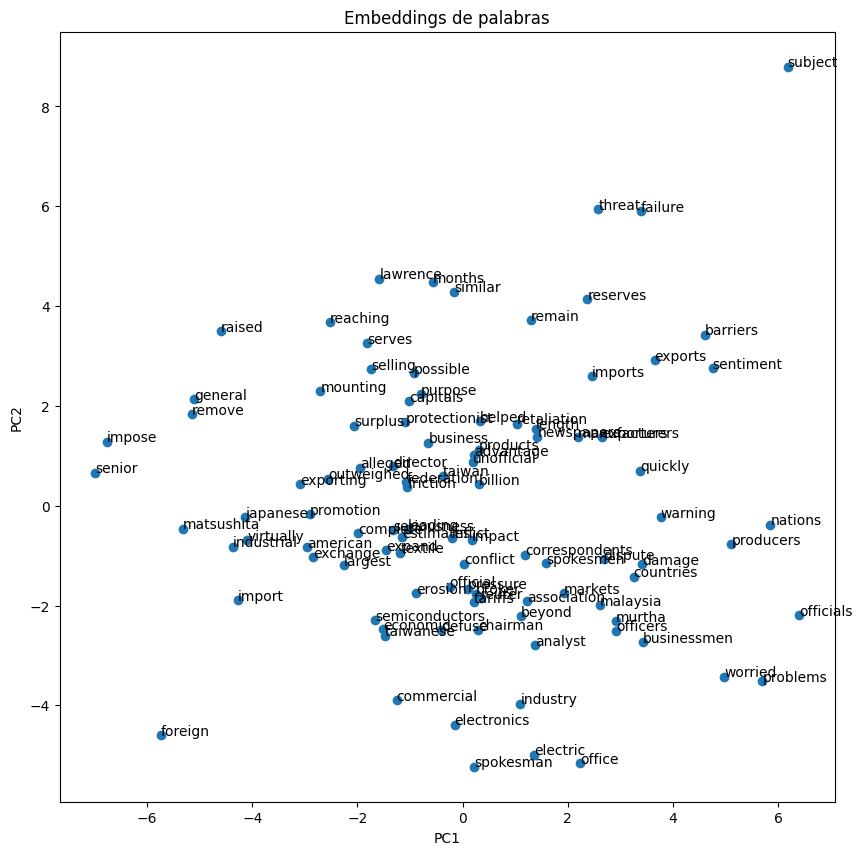

In [75]:
reducer = PCA(n_components=2)
embeddings_2d = reducer.fit_transform(embeddings)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Embeddings de palabras")

for i, word in enumerate(subseted_words):
    ax.annotate(word, (embeddings_2d[i,0], embeddings_2d[i,1]))
plt.show()

Podemos observar que si bien ciertas palabras relacionadas entre sí aparecen juntas como los son _worried_ y _problems_, _imports_ y _exports_, _electric_ y _electronics_; en general la represenetación no es muy buena ya qye gran parte de los embedings se distribuyen uniformemente al rededor de un cúmulo central, esto puede deberse a que el corpus de entrenamiento es relativamente pequeño y no muy diverso ya que se centra en noticias.

Ejemplos de similitud léxica con distancia coseno

In [77]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [78]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "king"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "queen"))).detach().numpy())

np.float32(0.030624213)

In [103]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "worried"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "problems"))).detach().numpy())

np.float32(0.13172017)

In [80]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "money"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "dollars"))).detach().numpy())

np.float32(0.103301026)

In [81]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "bussines"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "company"))).detach().numpy())

np.float32(-0.09633616)

In [82]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "nations"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "countries"))).detach().numpy())

np.float32(0.25734845)

In [89]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "foreigner"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "inmigrant"))).detach().numpy())

np.float32(0.99999994)

In [88]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "stock"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "asset"))).detach().numpy())

np.float32(0.27624932)

In [93]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "good"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "bad"))).detach().numpy())

np.float32(0.16288206)

In [97]:
cosine_similarity(model.embeddings(torch.tensor(get_word_id(words_indexes, "imports"))).detach().numpy(),
                  model.embeddings(torch.tensor(get_word_id(words_indexes, "exports"))).detach().numpy())

np.float32(0.23614289)

De la misma manera que en la representación gráfica, la similitud entre los embedings de palabras relacionadas, en general si presentan una similitud mayor a cero, pero no es el la similitud que se esperaría de sinónimos, sin embargo un caso curioso es el de _foreigner_ e _inmigrant_ que tienen una similitud casi de 1 lo que indica que ambos términos son utilizados como palabras equivalentes en el corpus de noticias.

In [107]:
def find_analogies(word1, word2, word3):
    """
    Encuentra una analogía del tipo "word1 es a word2 como word3 es a X".
    Utiliza embeddings de palabras para calcular la relación vectorial y encontrar
    la palabra más similar que complete la analogía.

    Args:
        word1 (str): Primera palabra de la relación
        word2 (str): Segunda palabra de la relación
        word3 (str): Tercera palabra que inicia la segunda parte de la relación

    Returns:
        str: La palabra que mejor completa la analogía "word1:word2 :: word3:?"

    Ejemplo:
        >>> find_analogies("rey", "hombre", "reina")
        "mujer"
    """
    # Convertir todas las palabras a minúsculas para normalización
    word1, word2, word3 = word1.lower(), word2.lower(), word3.lower()

    # Obtener los índices de las palabras en el vocabulario
    idx1 = get_word_id(words_indexes, word1)
    idx2 = get_word_id(words_indexes, word2)
    idx3 = get_word_id(words_indexes, word3)

    # Obtener los embeddings de las palabras (vectores numéricos)
    emb1, emb2, emb3 = model.embeddings(torch.tensor([idx1, idx2, idx3])).detach().numpy()

    # Calcular el vector prototipo para la analogía: (word2 - word1) + word3
    prototype = (emb2 - emb1) + emb3
    # Normalizar el vector prototipo
    prototype = prototype / np.linalg.norm(prototype)

    # Buscar la palabra más cercana en el espacio de embeddings
    closest_word = []
    min_cosine_dist = -2  # Inicializar con valor mínimo posible (-1 sería el mínimo real)

    for i in range(len(index_to_word)):
        # Saltar las palabras de entrada para no devolverlas como resultado
        if index_to_word[i] in {word1, word2, word3}:
            continue

        # Obtener embedding de la palabra candidata
        emb = model.embeddings(torch.tensor([i])).detach().numpy().flatten()
        # Calcular similitud coseno con el prototipo
        sim = cosine_similarity(prototype, emb)

        # Actualizar la palabra más cercana si encontramos mayor similitud
        if sim > min_cosine_dist:
            min_cosine_dist = sim
            closest_word = index_to_word[i]

    return closest_word

In [108]:
find_analogies("king", "man", "queen")

'everyone'

In [115]:
find_analogies("stock", "asset", "money")

'honor'

In [116]:
find_analogies("imports", "buy", "exports")

'provided'

In [123]:
find_analogies("mexico", "latin", "america")

'adp'

In [126]:
find_analogies("industry", "manufacturing", "banking")

'refining'

In [129]:
find_analogies("rich", "development", "poor")

'polo'

## Referencias

- [Language models - Lena Voita](https://lena-voita.github.io/nlp_course/language_modeling.html#generation_strategies)
- [A Neural Probabilistic Model - Bengio](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- Parte del código de esta práctica fue retomado del trabajo de la Dr. Ximena Guitierrez Vasques